# Nested Logit Model: Compute Willingness To Pay Indicators

In [1]:
import pandas as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable, Derive
import seaborn as sns
import matplotlib.pyplot as plt

**Import Optima data**

In [2]:
pandas = pd.read_csv("../../Data/6-Discrete Choice Models/optima.dat",sep='\t')
database = db.Database ("data/optima", pandas)

**Use collumn names as variables**

In [3]:
globals().update(database.variables)

**Exclude some unwanted entries**

In [4]:
exclude = (Choice == -1.)
database.remove(exclude)

**Define some dummy variables**

In [5]:
male = (Gender == 1)
female = (Gender == 2)
unreportedGender = (Gender == -1)

fulltime = (OccupStat == 1)
notfulltime = (OccupStat != 1)

**Rescale some data**

In [6]:
TimePT_scaled = TimePT / 200
TimeCar_scaled = TimeCar / 200
MarginalCostPT_scaled = MarginalCostPT / 10
CostCarCHF_scaled = CostCarCHF / 10
distance_km_scaled = distance_km / 5

**Compute normalizing weights for each alternative**

In [7]:
sumWeight = database.data['Weight'].sum()
normalized_Weight = Weight * len(database.data['Weight']) / sumWeight

**Create parameters to be estimated**

In [8]:
ASC_CAR              = Beta('ASC_CAR',0,None,None,0)
ASC_PT               = Beta('ASC_PT',0,None,None,1)
ASC_SM               = Beta('ASC_SM',0,None,None,0)
BETA_TIME_FULLTIME   = Beta('BETA_TIME_FULLTIME',0,None,None,0)
BETA_TIME_OTHER      = Beta('BETA_TIME_OTHER',0,None,None,0)
BETA_DIST_MALE       = Beta('BETA_DIST_MALE',0,None,None,0)
BETA_DIST_FEMALE     = Beta('BETA_DIST_FEMALE',0,None,None,0)
BETA_DIST_UNREPORTED = Beta('BETA_DIST_UNREPORTED',0,None,None,0)
BETA_COST            = Beta('BETA_COST',0,None,None,0)

**Define the utility functions**

\begin{align}
V_{PT} & = \beta_{PT} + \beta_{time_{fulltime}} X_{time_{PT}} X_{fulltime} + \beta_{time_{other}} X_{time_{PT}} X_{not\_fulltime} + \beta_{cost} X_{cost_{PT}} \\
V_{car} & = \beta_{car} + \beta_{time_{fulltime}} X_{time_{car}} X_{fulltime} + \beta_{time_{other}} X_{time_{car}} X_{not\_fulltime} + \beta_{cost} X_{cost_{car}} \\
V_{SM} & = \beta_{SM} + \beta_{male} X_{distance} X_{male} + \beta_{female} X_{distance} X_{female} + \beta_{unreported} X_{distance} X_{unreported}
\end{align}

In [9]:
V_PT = ASC_PT + BETA_TIME_FULLTIME * TimePT_scaled * fulltime + \
       BETA_TIME_OTHER * TimePT_scaled * notfulltime + \
       BETA_COST * MarginalCostPT_scaled
V_CAR = ASC_CAR + \
        BETA_TIME_FULLTIME * TimeCar_scaled * fulltime + \
        BETA_TIME_OTHER * TimeCar_scaled * notfulltime + \
        BETA_COST * CostCarCHF_scaled
V_SM = ASC_SM + \
       BETA_DIST_MALE * distance_km_scaled * male + \
       BETA_DIST_FEMALE * distance_km_scaled * female + \
       BETA_DIST_UNREPORTED * distance_km_scaled * unreportedGender

**Associate utility functions with alternatives and associate availability of alternatives**

In this example all alternatives are available for each individual

In [10]:
V = {0: V_PT,
     1: V_CAR,
     2: V_SM}

av = {0: 1,
      1: 1,
      2: 1}

**Define the nests**

1. Define the nests paramenters
2. List alternatives in nests

In [11]:
MU_NO_CAR = Beta('MU_NO_CAR', 1.,1.,None,0)

CAR_NEST = 1., [1]
NO_CAR_NEST = MU_NO_CAR, [0, 2]

nests = CAR_NEST, NO_CAR_NEST

**Define the WTP**

In [12]:
WTP_PT_TIME = Derive(V_PT,'TimePT') / Derive(V_PT,'MarginalCostPT')
WTP_CAR_TIME = Derive(V_CAR,'TimeCar') / Derive(V_CAR,'CostCarCHF')

**Define what we want to simulate**

In [13]:
simulate = {'weight': normalized_Weight,
            'WTP PT time': WTP_PT_TIME,
            'WTP CAR time': WTP_CAR_TIME}

**Define the Biogeme object**

In [14]:
biogeme = bio.BIOGEME(database, simulate, removeUnusedVariables=False)
biogeme.modelName = "optima_nested_logit_wtp"

**Retrieve the names of the variables we want to use. Then retrieve the results from the model that we estimated earlier**

In [15]:
betas = biogeme.freeBetaNames

results = res.bioResults(pickleFile='optima_nested_logit.pickle')
betaValues = results.getBetaValues ()

**Perform the simulation**

In [16]:
simulatedValues = biogeme.simulate(betaValues)

**Compute the WTP for the car and its confidence interval**

In [17]:
wtpcar = (60 * simulatedValues['WTP CAR time'] * simulatedValues['weight']).mean()

b = results.getBetasForSensitivityAnalysis(betas,size=100)
left,right = biogeme.confidenceIntervals(b,0.9)
wtpcar_left = (60 * left['WTP CAR time'] * left['weight']).mean()
wtpcar_right = (60 * right['WTP CAR time'] * right['weight']).mean()

**Print the Time WTP for car**

In [18]:
print(f"Average WTP for car: {wtpcar:.3g} CI:[{wtpcar_left:.3g},{wtpcar_right:.3g}]")

Average WTP for car: 3.96 CI:[2.11,7.41]


**Analize all WTP values**

In [19]:
print("Unique values: ", [f"{i:.3g}" for i in 60 * simulatedValues['WTP CAR time'].unique()])

Unique values:  ['2.42', '6.69']


**Check this for groups within the population. Define a subgroup that automatically does this for us**

In [20]:
def wtpForSubgroup(filter):
    size = filter.sum()
    sim = simulatedValues[filter]
    totalWeight = sim['weight'].sum()
    weight = sim['weight'] * size / totalWeight
    wtpcar = (60 * sim['WTP CAR time'] * weight ).mean()
    wtpcar_left = (60 * left[filter]['WTP CAR time'] * weight ).mean()
    wtpcar_right = (60 * right[filter]['WTP CAR time'] * weight ).mean()
    return wtpcar, wtpcar_left,wtpcar_right

**Filter: Full time workers**

In [21]:
filter = database.data['OccupStat'] == 1
w,l,r = wtpForSubgroup(filter)
print(f"WTP car for workers: {w:.3g} CI:[{l:.3g},{r:.3g}]")

WTP car for workers: 6.69 CI:[4.51,10.5]


**Filter: Females**

In [22]:
filter = database.data['Gender'] == 2
w,l,r = wtpForSubgroup(filter)
print(f"WTP car for females: {w:.3g} CI:[{l:.3g},{r:.3g}]")

WTP car for females: 3.17 CI:[1.41,6.51]


**Filter: Males**

In [23]:
filter = database.data['Gender'] == 1
w,l,r = wtpForSubgroup(filter)
print(f"WTP car for males: {w:.3g} CI:[{l:.3g},{r:.3g}]")

WTP car for males: 4.96 CI:[2.99,8.54]


**Plot the distribution of individuals and their WTP in the population**

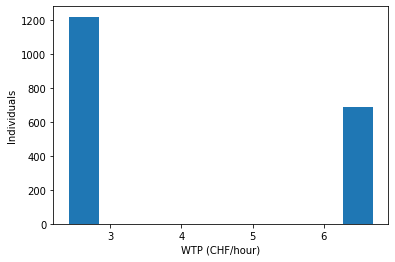

In [24]:
plt.hist(60*simulatedValues['WTP CAR time'],
         weights = simulatedValues['weight'])
plt.xlabel("WTP (CHF/hour)")
plt.ylabel("Individuals")
plt.show()